In [1]:
import pandas as pd
import numpy as np
import pickle

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import *
import torchvision
import torch

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from collections import Counter, defaultdict
from typing import List, Dict
import xarray as xr
import itertools
import logging
import joblib
import random
import sklearn
import scipy
import yaml
import sys
import os

from sklearn.linear_model import LogisticRegression

from holodecml.torch.utils import *
from holodecml.torch.losses import *
from holodecml.torch.transforms import *
from holodecml.torch.optimizers import *

from aimlutils.echo.src.base_objective import *
from aimlutils.torch.checkpoint import *
from aimlutils.utils.tqdm import *

import matplotlib.pyplot as plt 
import matplotlib.patches as patches

from data_reader import *

#from torchvision.references.detection.engine import train_one_epoch, evaluate

# Some references 
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# https://pytorch.org/vision/0.8/models.html
# https://blog.francium.tech/object-detection-with-faster-rcnn-bc2e4295bf49

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    import torch.backends.cudnn as cudnn
    cudnn.benchmark = True

In [3]:
work_directory = "results/3_12_cosine_low"

In [4]:
with open(f"{work_directory}/model.yml") as config_file:
    conf = yaml.load(config_file, Loader=yaml.FullLoader)

In [5]:
train_transform = LoadTransformations(conf["train_transforms"], device = device)
valid_transform = LoadTransformations(conf["validation_transforms"], device = device)

In [6]:
if "type" in conf["train_data"]:
    conf["train_data"].pop("type")
if "type" in conf["validation_data"]:
    conf["validation_data"].pop("type")
    
scaler_save = os.path.join(
    conf["callbacks"]["MetricsLogger"]["path_save"], 
    "scalers.pkl"
)

if os.path.isfile(scaler_save):
    with open(scaler_save, "rb") as fid:
        scalers = pickle.load(fid)
else:
    scalers = True

train_gen = DetectionDatasetPadded(
    **conf["train_data"],
    transform=train_transform,
    scaler=scalers,
)

valid_gen = DetectionDatasetPadded(
    **conf["validation_data"],
    transform=valid_transform,
    scaler=train_gen.scaler,
)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [8]:
conf["valid_iterator"]["batch_size"] = 2

train_dataloader = DataLoader(
    train_gen,
    **conf["train_iterator"],
    collate_fn = collate_fn
)

valid_dataloader = DataLoader(
    valid_gen,
    **conf["valid_iterator"],
    collate_fn = collate_fn
)

### Load model

In [9]:
# Initialze the model 
num_classes = conf["model"]["num_classes"]
pretrained = bool(conf["model"]["pretrained"])
pretrained_backbone = bool(conf["model"]["pretrained_backbone"])

# Load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained = pretrained, 
    pretrained_backbone = pretrained_backbone
)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load pretrained weights
model.load_state_dict(torch.load(f"{work_directory}/best.pt")["model_state_dict"])

# Set to eval mode
model = model.eval()

# Push to GPU device
model = model.to(device)

In [10]:
# https://pytorch.org/vision/stable/ops.html

# Optimize the IOU threshold and manual threshold

### First loop over the data and collect the predictions

In [11]:
results = {}

with torch.no_grad():
    
    batch_size = conf["valid_iterator"]["batch_size"]
    batches_per_epoch = int(np.ceil(valid_gen.__len__() / batch_size))

    batch_group_generator = tqdm(
        enumerate(valid_dataloader), 
        total=batches_per_epoch,
        leave=True
    )

    r = 0
    for idx, (images, targets) in batch_group_generator:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict, preds = model(images, targets)

        for pidx in range(len(images)):
            true_boxes = targets[pidx]['boxes']
            pred_boxes = preds[pidx]['boxes']
            scores = preds[pidx]['scores']
            results[r] = [true_boxes, pred_boxes, scores]
            r += 1

100%|██████████| 3000/3000 [04:35<00:00, 10.88it/s]


### Next optimize the thresholds on F1

In [12]:
def opt_threshold(params, full_metrics = False):
    
    iou_threshold = params[0]
    manual_threshold = params[1]
    
    iou_threshold = 0.0 if iou_threshold < 0.0 else iou_threshold
    iou_threshold = 1.0 if iou_threshold > 1.0 else iou_threshold
    manual_threshold = 0.0 if manual_threshold < 0.0 else manual_threshold
    manual_threshold = 1.0 if manual_threshold > 1.0 else manual_threshold

    metrics = {
        "recall": [],
        "precision": [],
        "f1_score": [], 
        "accuracy": []
    }
    minimize = []
    binary_output = defaultdict(list)
    
    for n, result in results.items():
        
        true_boxes, pred_boxes, scores = result
        # 1. Truncate via iou_threshold
        keep_idx = torchvision.ops.nms(pred_boxes, scores, iou_threshold)
        pred_boxes = torch.index_select(pred_boxes, 0, keep_idx)
        scores = torch.index_select(scores, 0, keep_idx)
        
        # 2. Truncate via manual_threshold
        keep_idx = torch.where(scores >= manual_threshold)
        pred_boxes = pred_boxes[keep_idx]
        scores = scores[keep_idx]
        
        # Compute binary metrics
        true_n = true_boxes.shape[0]
        pred_n = pred_boxes.shape[0]
        pad = max(true_n, pred_n)
        
        y_true = np.zeros(pad)
        y_pred = np.zeros(pad)
        y_true[:true_n] = 1
        y_pred[:pred_n] = 1
                    
        if full_metrics: # Post-optimization, get the full report 
            prec = sklearn.metrics.precision_score(y_true, y_pred)
            recall = sklearn.metrics.recall_score(y_true, y_pred)
            f1 = sklearn.metrics.f1_score(y_true, y_pred)
            accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
            metrics["recall"].append(recall)
            metrics["precision"].append(prec)
            metrics["f1_score"].append(f1)
            metrics["accuracy"].append(accuracy)
            for (i,j) in zip(y_true, y_pred):
                binary_output[true_n].append([i,j])
            
        else: # Minimization objective
            f1 = sklearn.metrics.f1_score(y_true, y_pred)
            minimize.append(1.0 - f1)
        
    if full_metrics:
        metrics = {key: np.mean(val) for key, val in metrics.items()}
        return metrics, {key: np.array(val) for key, val in binary_output.items()}
    else:
        val = np.mean(minimize)
        print(iou_threshold, manual_threshold, 1.0 - val)
        return val

In [34]:
guess = [0.0849500452502526, 0.11720792703217087]
best = scipy.optimize.fmin(opt_threshold, guess)

0.0849500452502526 0.11720792703217087 0.9563763974335676
0.08919754751276524 0.11720792703217087 0.9562799581305244
0.0849500452502526 0.12306832338377942 0.9563388878140031
0.08070254298773996 0.12306832338377943 0.9560090038547816
0.08707379638150892 0.11867302612007301 0.9560863952806737
0.0849500452502526 0.12013812520797515 0.9562582431700227
0.08707379638150892 0.11720792703217087 0.95626093782586
0.08707379638150892 0.11427772885636658 0.9561811990665274
0.08548098303306667 0.11867302612007301 0.9561659542529917
0.08601192081588076 0.11720792703217087 0.9563333650668027
0.0849500452502526 0.11867302612007301 0.9562168499895445
0.08601192081588074 0.11574282794426873 0.9563544790620273
0.08495004525025258 0.11574282794426871 0.9563994009662067
0.0844191074674385 0.11501027840031763 0.9562613011033867
0.08388816968462445 0.11720792703217085 0.956245899813045
0.08548098303306667 0.11610910271624425 0.9563120301917001
0.0849500452502526 0.11647537748821979 0.956338456631601
0.08548

In [35]:
best = [max(x, 0) for x in best]

print(best)

[0.08496767404382258, 0.11553965990668852]


In [36]:
full_metrics, binary_output = opt_threshold(best, full_metrics = True)

In [37]:
for key, val in full_metrics.items():
    val = np.round(val, 3)
    print(f"{key}: \t{val}")

recall: 	0.955
precision: 	0.966
f1_score: 	0.956
accuracy: 	0.922


### Confusion matrix

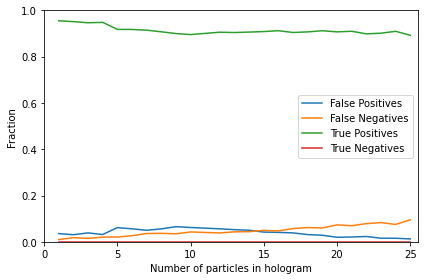

In [17]:
tns, fps, fns, tps = [], [], [], []
for key, val in sorted(binary_output.items()):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(val[:,0], val[:,1], normalize='all').ravel()
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)
    tps.append(tp)
parts = list(sorted(binary_output.keys()))
plt.plot(parts, fps)
plt.plot(parts, fns)
plt.plot(parts, tps)
plt.plot(parts, tns)
plt.legend(["False Positives", "False Negatives", "True Positives", "True Negatives"])
plt.xlabel(f"Number of particles in hologram")
plt.ylabel(f"Fraction")
plt.axis([0.0, 25.5, 0.0, 1.0])
plt.tight_layout()

### Compute the scatter plots using the optimized thresholds

In [18]:
def compute_results(params):
    
    iou_threshold = params[0]
    manual_threshold = params[1]

    results = {"x": [], "y": [], "z": [], "d": []}

    with torch.no_grad():

        batch_size = conf["valid_iterator"]["batch_size"]
        batches_per_epoch = int(np.ceil(valid_gen.__len__() / batch_size))

        batch_group_generator = tqdm(
            enumerate(valid_dataloader), 
            total=batches_per_epoch,
            leave=True
        )

        for idx, (images, targets) in batch_group_generator:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict, preds = model(images, targets)

            for pidx in range(len(images)):
                true_boxes = targets[pidx]['boxes']
                pred_boxes = preds[pidx]['boxes']
                scores = preds[pidx]['scores']

                # IOU threshold
                keep_idx = torchvision.ops.nms(pred_boxes, scores, iou_threshold)
                pred_boxes = torch.index_select(pred_boxes, 0, keep_idx)
                scores = torch.index_select(scores, 0, keep_idx)
                
                # Manual threshold
                keep_idx = torch.where(scores >= manual_threshold)                
                pred_boxes = pred_boxes[keep_idx]
                scores = scores[keep_idx]
                
                n_true = true_boxes.shape[0]
                p_true = pred_boxes.shape[0]
                largest = max(n_true, p_true)
                
                image_result = {
                    "true_x": np.zeros(largest),
                    "true_y": np.zeros(largest),
                    "true_z": np.zeros(largest),
                    "true_d": np.zeros(largest),
                    "pred_x": np.zeros(largest),
                    "pred_y": np.zeros(largest),
                    "pred_z": np.zeros(largest),
                    "pred_d": np.zeros(largest)
                }
                
                for i, box in enumerate(true_boxes):
                    xmin = box[0].item()
                    ymin = box[1].item()
                    xmax = box[2].item()
                    ymax = box[3].item()
                    width = xmax - xmin
                    height = ymax - ymin
                    image_result["true_x"][i] = (xmax + xmin) / 2.0 
                    image_result["true_y"][i] = (ymax + ymin) / 2.0 
                    image_result["true_d"][i] = np.sqrt(width * height)
                    
                for i, box in enumerate(pred_boxes):
                    xmin = box[0].item()
                    ymin = box[1].item()
                    xmax = box[2].item()
                    ymax = box[3].item()
                    width = xmax - xmin
                    height = ymax - ymin
                    image_result["pred_x"][i] = (xmax + xmin) / 2.0 
                    image_result["pred_y"][i] = (ymax + ymin) / 2.0 
                    image_result["pred_d"][i] = np.sqrt(width * height) 
                    
                for key in results:
                    for t,p in zip(image_result[f"true_{key}"], image_result[f"pred_{key}"]):
                        results[key].append([t,p])
                        
    return results 

In [19]:
compare_results = compute_results(best)

100%|██████████| 3000/3000 [04:48<00:00, 10.40it/s]


### Transform data back to original format in um

In [20]:
compare_results = {key: train_gen.scaler[key].inverse_transform(val) for key, val in compare_results.items()}

In [21]:
def density_plot(results, name, plot_min, plot_max, savepath):
    x, y = zip(*results)
    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    gridsize = 50 if name != "d" else 100
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap='rainbow')
    plt.axis('scaled')
    ax.axis([plot_min, plot_max, plot_min, plot_max])
    plt.plot(range(int(plot_min), int(plot_max)), range(int(plot_min), int(plot_max)), color = "k", ls = "--", lw = 2)
    ax.set_title(f"Relationship in {name}")
    ax.set_xlabel(f"Predicted {name}")
    ax.set_ylabel(f"True {name}")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Counts')
    plt.tight_layout()
    plt.savefig(os.path.join(savepath, f'{name}.png'), bbox_inches='tight')
    plt.show()

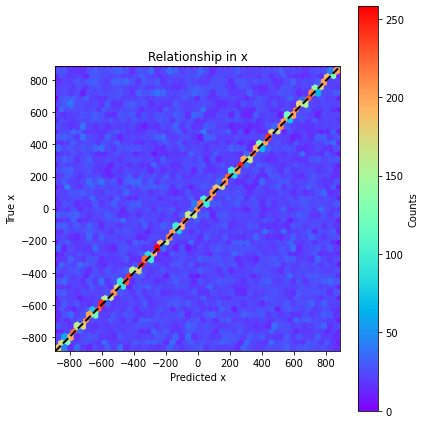

In [22]:
density_plot(compare_results["x"], "x", -888, 888, work_directory)

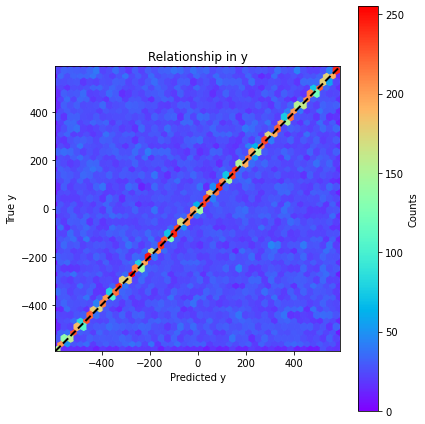

In [23]:
density_plot(compare_results["y"], "y", -592, 592, work_directory) 

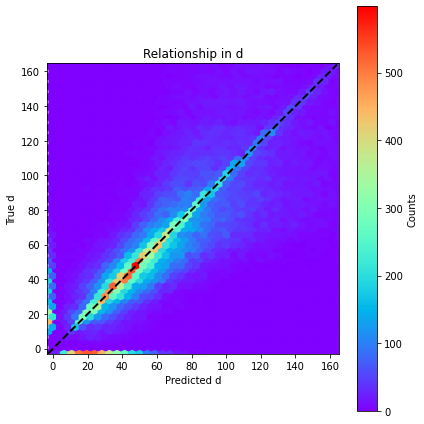

In [24]:
density_plot(compare_results["d"], "d", np.amin(compare_results["d"])-1, 165, work_directory)

### Visualize

In [30]:
images, targets = next(iter(valid_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
loss_dict, preds = model(images, targets)

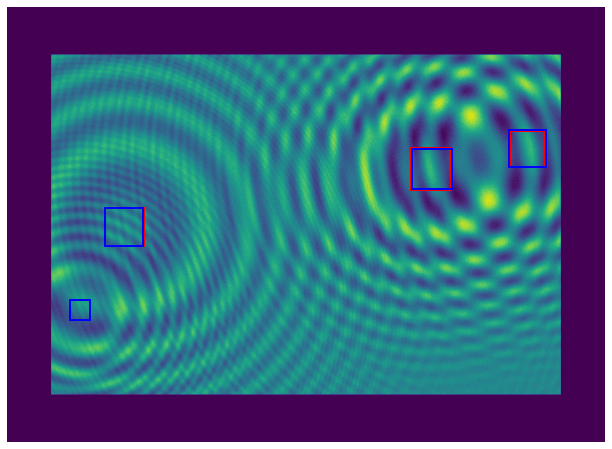

<Figure size 432x288 with 0 Axes>

In [31]:
idx = 0
sample = images[idx].permute(1,2,0).squeeze(2).cpu().numpy()
true_boxes = targets[idx]['boxes'].data.cpu().numpy()

pred_boxes = preds[idx]['boxes']
scores = preds[idx]['scores']

keep_idx = torchvision.ops.nms(pred_boxes, scores, best[0])
pred_boxes = pred_boxes[keep_idx].data.cpu().numpy()
scores = scores[keep_idx].data.cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize = (12, 8))

for k, (box, score) in enumerate(zip(pred_boxes, scores)):
    
    if score < best[1]:
        continue
    
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    
    width = xmax - xmin
    height = ymax - ymin
            
    plt.gca().add_patch(
        patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
    )
    
for box in true_boxes:
    
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    
    width = xmax - xmin
    height = ymax - ymin
            
    plt.gca().add_patch(
        patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='b', facecolor='none')
    )
    
ax.set_axis_off()

plt.imshow(sample)

#plt.savefig(os.path.join(work_directory, f'example_{idx}.png'), bbox_inches='tight')
plt.show()

plt.clf()